In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor, Button
from scipy import signal
import math
import os

directory  = 'data/Research_B/Data/'
AllHeartbeats = []
AllPeaks = []
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if os.path.isfile(f):
        
        highest_peak_values = []
        highest_peak_indices = []

        data = []
        RMSSD = []

        with open(f, 'r') as file:
            data_started = False
            for line in file:
                # Check if the line contains data
                if data_started:
                    values = line.strip().split()
                    data.append([int(val) for val in values])
                elif line.strip() == "# EndOfHeader":
                    data_started = True

            # Convert the data into a NumPy array
            data = np.array(data)

            heartbeat_data = data[:, 2]

            #Toggle inverse heartbeatdata
            if False:
                heartbeat_data = -heartbeat_data

            heightthreshold = 150  # Adjust this threshold as needed
            widthtreshold = 200


            #Butterworth filter
            sos = signal.butter(2, 3, 'highpass',fs = 1000, output = 'sos')
            filtered = signal.sosfilt(sos, heartbeat_data)

            # Create an array for the x-axis (time)
            time = np.arange(len(heartbeat_data))

            peaks, _ = signal.find_peaks(filtered, height=heightthreshold, distance= widthtreshold)
            AllHeartbeats.append(heartbeat_data)
            AllPeaks.append(peaks)
            print(count, end=' ')
            count += 1


        



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

In [20]:
#--------------------- Nieuwe berekening -------------------------
interval = 29000  # Meettijd per HRV waarde (ms)

All_HRV = []

def calculate_rmssd(heartbeat_data, peaks):
    HRVRMSSD = []
    waarde1 = 0
    waarde2 = interval

    for i in range(int((len(heartbeat_data) - interval) / 1000)):
        peaks_in_range_interval = [peak for peak in peaks if waarde1 <= peak <= waarde2]
        squared_differences = [(heartbeat_data[peaks[i+1]] - heartbeat_data[peaks[i]]) ** 2 for i in range(len(peaks_in_range_interval)-1)]
        mean_squared_diff = sum(squared_differences) / (len(peaks_in_range_interval) - 1)
        rmssd_value = math.sqrt(mean_squared_diff)
        HRVRMSSD.append(rmssd_value)
        waarde1 += 1000
        waarde2 += 1000

    return HRVRMSSD

# Voer de functie uit om HRVRMSSD te berekenen
count = 0
for peaks in AllPeaks:
    HRVRMSSD = calculate_rmssd(AllHeartbeats[count], peaks)
    All_HRV.append(HRVRMSSD)
    print(count, end=' ')
    count += 1

print('')
print(All_HRV[0])

'''
# Plot de HRV data met de RMSSD formule
# Maak een figuur en as-object
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVRMSSD, label='HRV - RMSSD')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - Nieuw RMSSD')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)
ax.legend()
'''


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
[51.28403876040719, 51.28403876040719, 51.28403876040719, 51.28403876040719, 51.737904971218256, 51.737904971218256, 51.28403876040719, 51.737904971218256, 51.737904971218256, 51.737904971218256, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.871820040227185, 50.989618320503126, 50.989618320503126, 51.871820040227185, 51.871820040227185, 51.871820040227185, 50.989618320503126, 51.871820040227185, 51.871820040227185, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.871820040227185, 51.423621895865026, 51.423621895865026, 51.423621895865026, 51.42

'\n# Plot de HRV data met de RMSSD formule\n# Maak een figuur en as-object\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Voeg de lijnplot toe aan de as\nax.plot(HRVRMSSD, label=\'HRV - RMSSD\')\n\n# Stel de titel en labels in\nax.set_xlabel(\'Time (Row Index)\')\nax.set_ylabel(\'Amplitude\')\nax.set_title(\'HRV data - Nieuw RMSSD\')\n\n# Voeg een raster en een legenda toe\nax.grid(True)\nax.legend()\n\nax.set_xlim(0, 1500)\n\nax.axvspan(180, 330, color="red", alpha=0.3)\nax.axvspan(330, 570, color="green", alpha=0.3)\nax.axvspan(570, 720, color="red", alpha=0.3)\nax.axvspan(720, 960, color="green", alpha=0.3)\nax.axvspan(960, 1110, color="red", alpha=0.3)\nax.axvspan(1110, 1350, color="green", alpha=0.3)\nax.legend()\n'

In [19]:
#Calculate HRV with RMSSD

interval = 30000 #Meettijd per HRV waarde (ms)
All_HRV2 = []
def calculate_rmssd2(heartbeat_data, peaks):

    HRVRMSSD2 = []
    waarde1 = 0
    waarde2 = interval
    RMSSD2 = []

    for i in range(int((len(heartbeat_data) - interval) / 1000)):
        peaks_in_range = [peak for peak in peaks if waarde1 <= peak <= waarde2]
        
        # Neem de kwadraten van de verschillen tussen de pieken
        squared_differences = [(heartbeat_data[peaks_in_range[i+1]] - heartbeat_data[peaks_in_range[i]]) ** 2 for i in range(len(peaks_in_range)-1)]

        # Bereken de RMSSD-waarde voor dit interval
        rmssd_value = math.sqrt(sum(squared_differences) / (len(peaks_in_range) - 1))
        HRVRMSSD2.append(rmssd_value)

        # Verschuif het tijdvenster met 1 seconde (1000 ms)
        waarde1 += 1000
        waarde2 += 1000

    return HRVRMSSD2


count = 0
for peaks in AllPeaks:
    HRVRMSSD2 = calculate_rmssd2((AllHeartbeats[count]), peaks)
    All_HRV2.append(HRVRMSSD2)
    print(count, end=' ')
    count += 1
print('')
print((All_HRV2[0]))
    
#plot de HRV data met de RMSSD formule
# Maak een figuur en as-object
'''
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVRMSSD, label='HRV - RMSSD')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - RMSSD')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)

plt.show()
'''

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
[53.8961965262856, 54.97248729113827, 54.91648671228443, 56.37102365304632, 54.12558496098145, 53.05077393765915, 50.71008598408033, 49.682942111373656, 48.93147732987642, 48.80627655925975, 45.62538411537678, 44.94763034559453, 45.33121351694568, 44.565166375253824, 43.81843853397284, 42.68615827300588, 42.737096993823286, 42.18938781784401, 41.43082805729948, 41.49894169930315, 40.84247921108742, 40.838094960465526, 40.26097298806806, 39.79181937143474, 40.30370812827139, 39.706354587075786, 38.60411607300156, 37.27935085271738, 37.30207024341202, 36.18279210404366, 31.612384553254714, 32.415702642049546, 29.33901460134232, 29.314861608254457, 29.52635357702599, 30.01619933006546, 29.576642435844164, 31.388692231439016, 31.680414275205568, 31.591137997862628, 31.25397272045285, 31.934476836341172, 31.628331466445577, 32.0396713550645, 32.07556866624749, 32.42913271502414, 33.25251463768

'\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Voeg de lijnplot toe aan de as\nax.plot(HRVRMSSD, label=\'HRV - RMSSD\')\n\n# Stel de titel en labels in\nax.set_xlabel(\'Time (Row Index)\')\nax.set_ylabel(\'Amplitude\')\nax.set_title(\'HRV data - RMSSD\')\n\n# Voeg een raster en een legenda toe\nax.grid(True)\nax.legend()\n\nax.set_xlim(0, 1500)\n\nax.axvspan(180, 330, color="red", alpha=0.3)\nax.axvspan(330, 570, color="green", alpha=0.3)\nax.axvspan(570, 720, color="red", alpha=0.3)\nax.axvspan(720, 960, color="green", alpha=0.3)\nax.axvspan(960, 1110, color="red", alpha=0.3)\nax.axvspan(1110, 1350, color="green", alpha=0.3)\n\nplt.show()\n'

In [21]:
#Calculate HRV with SDNN

All_HRV3 = []
def calculate_sdnn(heartbeat_data, peaks):
    waarde1 = 0
    waarde2 = interval
    peaks_in_range_interval = 0
    peaks_in_range_interval2 = len([peak for peak in peaks if waarde1 <= peak <= waarde2])

    SDNNGem = 0
    SDNN = []
    HRVSDNN = []
    SDNNV = 0

    r=0

    for i in range(int((len(heartbeat_data)-interval)/1000)):
        #Tel meetwaardes bij elkaar op en deel deze door het aantal waardes om het gemiddelde te berekenen.
        for j in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNNGem += heartbeat_data[peaks[peaks_in_range_interval]]
        SDNNGem = SDNNGem/(peaks_in_range_interval2 - peaks_in_range_interval)

        #Bereken de afwijking per meetwaarde ten opzichte van het gemiddelde en neem hier het kwadraat van
        for g in range(peaks_in_range_interval, peaks_in_range_interval2):
            SDNN.append(math.pow(heartbeat_data[peaks[peaks_in_range_interval+r]] - SDNNGem, 2)) #heartbeat_data vervangen door pieken
            r = r+1

        #Tel de gekwadrateerde afwijkingen bij elkaar op en deel deze door het aantal meet meetwaardes, en neem hier vervolgens de wortel van
        SDNNV = sum(SDNN)
        HRVSDNN.append(math.sqrt(SDNNV/len(SDNN)))

        #Reset variabelen
        r = 0
        SDNNGem = 0
        SDNNV = 0
        SDNN = []

        #Verschuif het window met 1 seconden (1000 ms)
        waarde1 = waarde1 + 1000
        waarde2 = waarde2 + 1000
        peaks_in_range_interval = len([peak for peak in peaks if 0 <= peak <= waarde1])
        peaks_in_range_interval2 = len([peak for peak in peaks if 0 <= peak <= waarde2])
    return HRVSDNN

count = 0
for peaks in AllPeaks:
    HRVSDNN = calculate_sdnn((AllHeartbeats[count]), peaks)
    All_HRV3.append(HRVSDNN)
    print(count, end=' ')
    count += 1
print('')
print((All_HRV3[0]))

'''
# Maak een figuur en as-object
fig, ax = plt.subplots(figsize=(12, 6))

# Voeg de lijnplot toe aan de as
ax.plot(HRVSDNN, label='HRV - SDNN')

# Stel de titel en labels in
ax.set_xlabel('Time (Row Index)')
ax.set_ylabel('Amplitude')
ax.set_title('HRV data - SDNN')

# Voeg een raster en een legenda toe
ax.grid(True)
ax.legend()

ax.set_xlim(0, 1500)

ax.axvspan(180, 330, color="red", alpha=0.3)
ax.axvspan(330, 570, color="green", alpha=0.3)
ax.axvspan(570, 720, color="red", alpha=0.3)
ax.axvspan(720, 960, color="green", alpha=0.3)
ax.axvspan(960, 1110, color="red", alpha=0.3)
ax.axvspan(1110, 1350, color="green", alpha=0.3)

plt.show()
'''

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
[60.814134659295895, 43.8520238985614, 47.0365378980628, 59.89349521634857, 131.45151197304654, 96.43336941558199, 39.041398146464594, 43.31190428313651, 51.53588427902496, 40.56151922826934, 68.09829937948803, 45.74872616746772, 51.78437623088282, 46.195822906990784, 78.94565641418575, 38.86050551509706, 37.13452535004282, 37.52813759182716, 50.496699562116596, 53.299257131885156, 40.936998397999794, 70.10507986032269, 63.93116958451835, 34.62337039887622, 42.129430198958175, 50.033322229623465, 34.74030640177039, 64.4437739428721, 42.78142120126446, 43.159587579123134, 44.93900628311985, 52.52020019546221, 49.12936438062724, 33.1566148922219, 36.67954319356893, 29.781106186881065, 41.0731055558257, 65.98232086450632, 73.56875091444132, 62.01460159358287, 39.96180608963947, 26.04589965597059, 41.11421139190655, 30.966852373884336, 37.33884290104862, 26.388470045672435, 38.93098536669245,

'\n# Maak een figuur en as-object\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Voeg de lijnplot toe aan de as\nax.plot(HRVSDNN, label=\'HRV - SDNN\')\n\n# Stel de titel en labels in\nax.set_xlabel(\'Time (Row Index)\')\nax.set_ylabel(\'Amplitude\')\nax.set_title(\'HRV data - SDNN\')\n\n# Voeg een raster en een legenda toe\nax.grid(True)\nax.legend()\n\nax.set_xlim(0, 1500)\n\nax.axvspan(180, 330, color="red", alpha=0.3)\nax.axvspan(330, 570, color="green", alpha=0.3)\nax.axvspan(570, 720, color="red", alpha=0.3)\nax.axvspan(720, 960, color="green", alpha=0.3)\nax.axvspan(960, 1110, color="red", alpha=0.3)\nax.axvspan(1110, 1350, color="green", alpha=0.3)\n\nplt.show()\n'

Epoch 1/500
2/2 [==============================] - 1s 235ms/step - loss: 0.2465 - val_loss: 0.2439
Epoch 2/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2436 - val_loss: 0.2412
Epoch 3/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2407 - val_loss: 0.2384
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2379 - val_loss: 0.2357
Epoch 5/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2351 - val_loss: 0.2330
Epoch 6/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2323 - val_loss: 0.2303
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2296 - val_loss: 0.2276
Epoch 8/500
2/2 [==============================] - 0s 17ms/step - loss: 0.2268 - val_loss: 0.2249
Epoch 9/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2240 - val_loss: 0.2222
Epoch 10/500
2/2 [==============================] - 0s 16ms/step - loss: 0.2213 - val_loss: 0.2195
Epoch 11/500
2/2 [

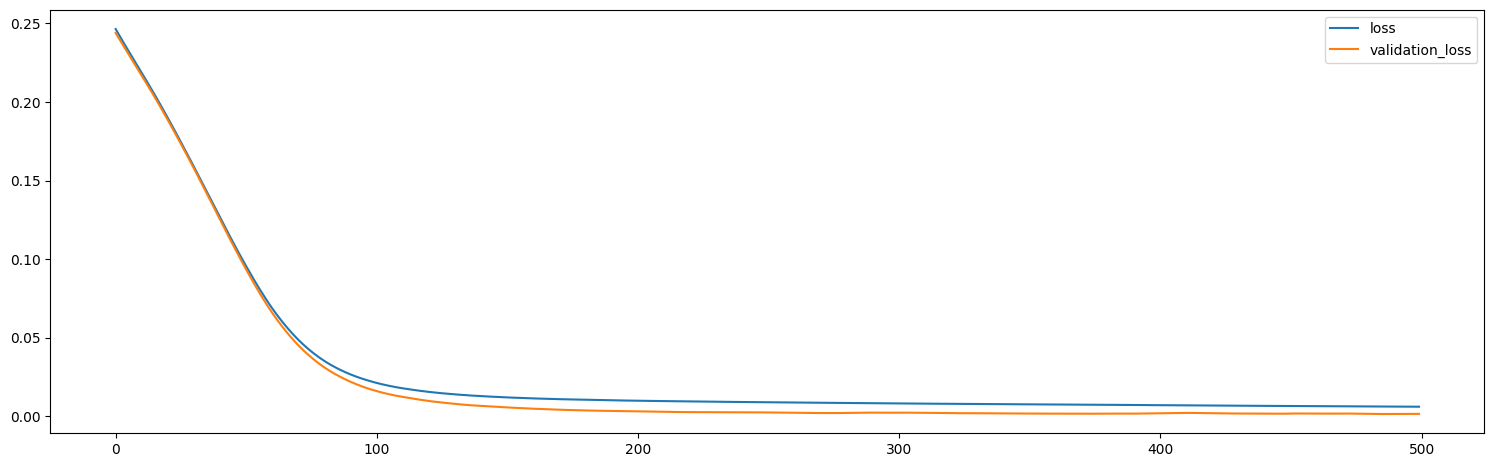

In [4]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from sklearn.metrics import r2_score

tf.get_logger().setLevel('ERROR')

# Load and process data
data = pd.read_csv('HRVData.txt', sep='\t')

columns = ['HRV', 'Stress']
data = data[columns]

X = data[['HRV']]
Y = data['Stress']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


# AI model
model = Sequential()
batch_size = 128
epochs = 200

model.add(LSTM(batch_size, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='mean_squared_error', metrics=[])

train_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)
score = model.evaluate(X_test, Y_test, batch_size=batch_size)

# Print training results
print("Loss: {:0.4f}".format(score))

# Model voorspelt waarschijnlijkheden per klasse
y_pred_prob = model.predict(X_test)

#print('Accuracy: {:0.3}'.format(100 * accuracy_score(Y_test, 1 * (y_pred_prob > 0.5))))
mae = mean_absolute_error(Y_test, y_pred_prob)
print('Mean Absolute Error (MAE): {:0.3f}'.format(mae))
mse = mean_squared_error(Y_test, y_pred_prob)
print('Mean Squared Error (MSE): {:0.3f}'.format(mse))
r_squared = r2_score(Y_test, y_pred_prob)
print('R² (R-squared): {:0.3f}'.format(r_squared))

# Plot accuracy history
loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)
loss = train_history.history['loss']
validation_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(validation_loss)
plt.legend(['loss', 'validation_loss'])
plt.show()


In [14]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import shutil
import os
from sklearn.metrics import accuracy_score


tf.get_logger().setLevel('ERROR')

# Load and process data
data = pd.read_csv('HRVRuis.txt', sep='\t')

columns = ['HRV', 'Stress']
data = data[columns]

X = data[['HRV']]
Y = data['Stress']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

epochs = 150
batch_size = 128

if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(1, X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']), loss='mean_squared_error', metrics=[])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # You can adjust the number of trials
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning')

tuner.search(X_train, Y_train, epochs=epochs, validation_split=0.1, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model to your data
best_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=1)
score = best_model.evaluate(X_test, Y_test, batch_size=batch_size)

# Print training results
print("Loss: {:0.4f}".format(score))

# Model voorspelt waarschijnlijkheden per klasse
y_pred_prob = best_model.predict(X_test)
y_pred = best_model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

mae = mean_absolute_error(Y_test, y_pred_prob)
print('Mean Absolute Error (MAE): {:0.3f}'.format(mae))
mse = mean_squared_error(Y_test, y_pred_prob)
print('Mean Squared Error (MSE): {:0.3f}'.format(mse))
r_squared = r2_score(Y_test, y_pred_prob)
print('R² (R-squared): {:0.3f}'.format(r_squared))
accuracy = accuracy_score(Y_test, y_pred_binary)
print('Accuracy: {:0.3f}'.format(accuracy))


Trial 5 Complete [00h 00m 09s]
val_loss: 0.1990078091621399

Best val_loss So Far: 0.0011590843787416816
Total elapsed time: 00h 00m 44s
Epoch 1/150
2/2 [==============================] - 1s 228ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 2/150
2/2 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 3/150
2/2 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 4/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 5/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 6/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 7/150
2/2 [==============================] - 0s 15ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 8/150
2/2 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 9/150
2/2 [==============================] - 0s 17ms/step - loss: 0.0075